#### **Objective:**

The objective is to enhance the dataset from [TheGlobalEconomy.com data](https://www.theglobaleconomy.com/download-data.php) by incorporating correlations from news reports sourced from the [European Social Survey (ESS)](https://www.europeansocialsurvey.org/data). This augmentation aims to facilitate experiments in predicting target values, such as the happiness index classification/prediction, by leveraging various attributes and sentiments from the ESS data. The analysis also plans to explore whether external factors, such as economic indicators or sentiment from news reports, can improve the prediction accuracy of happiness levels or other metrics, and if so, by how much.

**Examples from TheGlobalEconomy.com data:**

- **Country:** Name of the country.
- **Code:** Country code.
- **ContinentCode**
- **Year:** The specific year corresponding to the data.
- **GDP per capita current U.S. dollars:** Gross Domestic Product (GDP) per capita, measured in current U.S. dollars.
- **Gini income inequality index:** Measure of income inequality within a population (0 represents perfect equality, while an index of 100 implies perfect inequality).
- **Happiness Index 0-10:** Scale representing happiness level, ranging from 0 (unhappy) to 10 (happy).

**Fields in the ESS data:**

- **pubdate:** Publication date of the article.
- **guid:** Globally Unique Identifier, providing a unique reference for the article.
- **link:** URL link to the source or publication of the article.
- **source_country:** Country where the information source is located.
- **main_country_x:** Primary country mentioned in the context of the article.
- **main_country_y:** Another country mentioned prominently in the article.
- **other_country_x, other_country_y, other_country_z:** Additional countries referenced in the article.
- **tonality:** The overall tone or style of the article, categorized as positive, negative, or neutral.
- **sentiment:** The emotional tone or attitude expressed in the article, classified as positive, negative, or neutral.
- **title:** The headline or title of the article.

Since access to the complete dataset is unavailable at this moment, a proxy dataset [Madhurima Panja. (2023). Happiness Index.](https://www.kaggle.com/competitions/happiness-index) will be utilized. Although the feature variables are similarly defined, the dataset from [TheGlobalEconomy.com data](https://www.theglobaleconomy.com/download-data.php) will offer a broader scope, covering multiple years and more economical factors.

***
***


**Current Task description ([Madhurima Panja. (2023). Happiness Index.](https://www.kaggle.com/competitions/happiness-index)):**

The happiness index of a country plays a crucial role in the well-being and prosperity of its residents. Generally, a country's happiness level depends on different social, economic, and cultural factors, significantly impacting the happiness score. With 22 explanatory variables describing (almost) every aspect of social, economic, and cultural features (Xs) in different countries (masked as Id's), the goal is to predict their happiness score (Happiness, Y).

In [1]:
import pandas as pd

# Load the data
features = pd.read_csv('data/Features_Train.csv', index_col=0)
output = pd.read_csv('data/Output_Train.csv', index_col=0)
dataset = features.merge(output, left_index=True, right_index=True)

# get dataset column names
columns_names = dataset.columns.values.tolist()

# Replace commas and convert to float64
for col in columns_names:
    dataset[col] = dataset[col].replace({',': ''}, regex=True).astype(float)

dataset.head()

# save it to a csv file
dataset.to_csv('data/dataset.csv', index=False)

In [2]:
# load the dataset from the csv file
dataset = pd.read_csv('data/dataset.csv')

# shape of the data
print(dataset.shape)

(116, 23)


In [3]:
"""Checking the happiness distribution across the different classes"""

# Bin the Happiness scores into classes
bins = [i for i in range(1, 11)]  # Define the bin edges
dataset['Happiness_Class'] = pd.cut(dataset['Happiness'], bins=bins, right=False, labels=[f'{i}-{i+1}' for i in range(1, 10)])

# Count the occurrences of each class
class_counts = dataset['Happiness_Class'].value_counts().sort_index()

print("Happiness Class Counts:")
print(class_counts)

Happiness Class Counts:
Happiness_Class
1-2      0
2-3      3
3-4      5
4-5     26
5-6     40
6-7     29
7-8     13
8-9      0
9-10     0
Name: count, dtype: int64


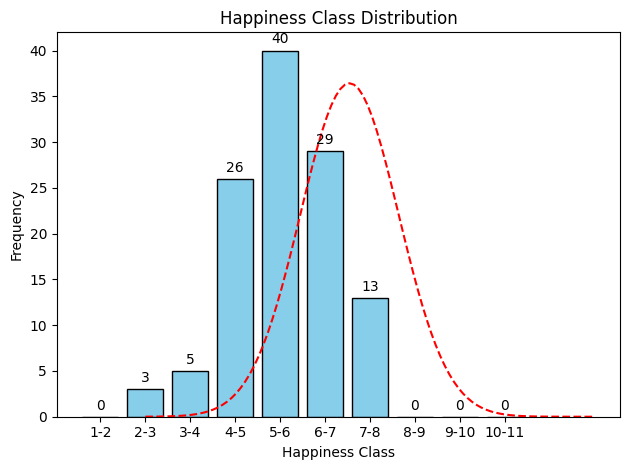

In [4]:
"""Checking how they look like in a bar plot as compared to a bell curve"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Bin the Happiness scores into classes
bins = [i for i in range(1, 12)]  # Extend the range to include 10-11
dataset['Happiness_Class'] = pd.cut(dataset['Happiness'], bins=bins, right=False, labels=[f'{i}-{i+1}' for i in range(1, 11)])

# Count the occurrences of each class
class_counts = dataset['Happiness_Class'].value_counts().sort_index()

# Plotting
fig, ax = plt.subplots()

# Bar plot
bars = ax.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Bell curve
mu = np.mean(dataset['Happiness'])
sigma = np.std(dataset['Happiness'])
x = np.linspace(1, 11, 100)
y = 100 * np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
ax.plot(x, y, linestyle='--', color='red')

# Add labels and title
ax.set_xlabel('Happiness Class')
ax.set_ylabel('Frequency')
ax.set_title('Happiness Class Distribution')

plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = dataset.drop(['Happiness', 'Happiness_Class'], axis=1)  # Features
y = dataset['Happiness']  # Target

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (92, 22)
Validation set size: (24, 22)


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import RidgeCV
from tqdm import tqdm

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42),
    "Lasso": Lasso(alpha=0.1, precompute=True, warm_start=True, positive=True, selection='random', random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42),
    "PolynomialRegression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "SGDRegressor": SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=1000, random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "StackingRegressor": StackingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('ridge', RidgeCV()),
            ('svr', LinearSVR(dual="auto", max_iter=100000, random_state=42))  # Increase max_iter here
        ],
        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    )
}

# Initialize lists to store results
train_results = []
val_results = []

# Define KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Perform cross-validation
for model_name, model in tqdm(models.items(), desc="Models", total=len(models)):
    for train_index, val_index in kf.split(X_normalized):
        X_train, X_val = X_normalized[train_index], X_normalized[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Flatten y
        y_train = np.ravel(y_train)
        y_val = np.ravel(y_val)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        # Calculate metrics
        train_mae = mean_absolute_error(y_train, train_pred)
        val_mae = mean_absolute_error(y_val, val_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        val_mse = mean_squared_error(y_val, val_pred)
        train_rmse = root_mean_squared_error(y_train, train_pred)
        val_rmse = root_mean_squared_error(y_val, val_pred)
        train_r2 = r2_score(y_train, train_pred)
        val_r2 = r2_score(y_val, val_pred)

        # Append results to lists
        train_results.append([model_name, train_mae, train_mse, train_rmse, train_r2])
        val_results.append([model_name, val_mae, val_mse, val_rmse, val_r2])

# Convert results to DataFrames
train_columns = ["Model", "MAE", "MSE", "RMSE", "R2"]
val_columns = ["Model", "MAE", "MSE", "RMSE", "R2"]
train_kfold_cv = pd.DataFrame(train_results, columns=train_columns)

# condense the results to show the mean of the results, sorted by R2
train_kfold_cv.groupby('Model').mean().sort_values(by='R2', ascending=False)

Models: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


,MAE,MSE,RMSE,R2
Model,,,,
PolynomialRegression,7.876565e-15,1.520108e-28,1.156995e-14,1.000000
GradientBoostingRegressor,5.623553e-02,6.075797e-03,7.762159e-02,0.994932
RandomForestRegressor,1.753601e-01,6.019554e-02,2.451355e-01,0.949772
DecisionTreeRegressor,2.067747e-01,8.085209e-02,2.822791e-01,0.932473
AdaBoostRegressor,2.529915e-01,8.697896e-02,2.947091e-01,0.927323
LinearRegression,4.054007e-01,2.834487e-01,5.318286e-01,0.763490
ElasticNet,4.384502e-01,3.408081e-01,5.834282e-01,0.715485
Ridge,4.436677e-01,3.470370e-01,5.888420e-01,0.710137
Lasso,4.586399e-01,3.784443e-01,6.147295e-01,0.684203


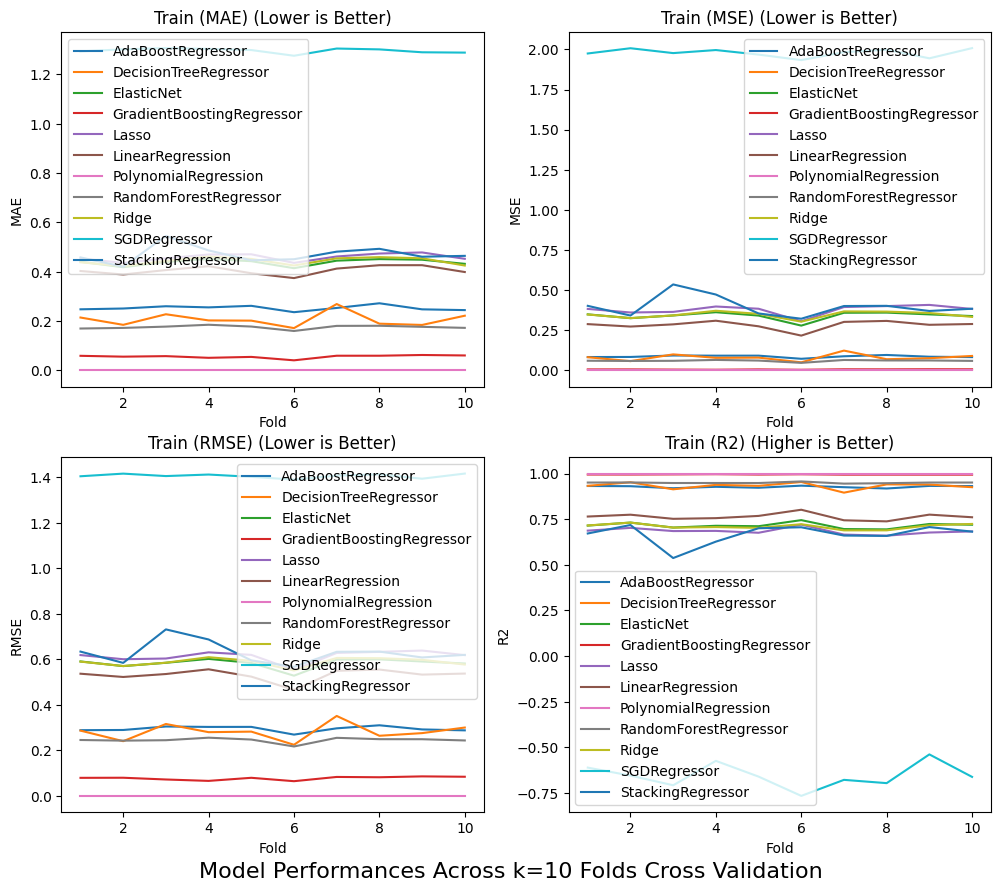

In [7]:
import matplotlib.pyplot as plt

def plot_model_performance(train_kfold_cv, set_name, super_title):
    # Define metrics and their corresponding titles
    metrics = ["MAE", "MSE", "RMSE", "R2"]
    titles = ["{} (MAE)".format(set_name), "{} (MSE)".format(set_name), "{} (RMSE)".format(set_name), "{} (R2)".format(set_name)]

    # Define whether higher or lower values are better for each metric
    better_higher = [False, False, False, True]  # Change False to True for R2

    # Create a grid of 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Iterate over each metric, corresponding title, and better_higher flag
    for i, (metric, title, higher_is_better) in enumerate(zip(metrics, titles, better_higher)):
        # Group the DataFrame by model and extract the scores for the current metric
        grouped = train_kfold_cv.groupby("Model")[metric].apply(list)

        # Plot each model's performance across folds
        for model, scores in grouped.items():
            axes[i].plot(range(1, len(scores) + 1), scores, label=model)

        # Set title and labels for the subplot
        axes[i].set_title(title + (" (Higher is Better)" if higher_is_better else " (Lower is Better)"))
        axes[i].set_xlabel("Fold")
        axes[i].set_ylabel(metric)
        axes[i].legend()

    # Adjust layout to prevent overlap and add space at the bottom
    plt.subplots_adjust(bottom=0.1)

    # Show the plot
    plt.suptitle(super_title, fontsize=16, y=0.05)
    plt.show()

# Example usage
plot_model_performance(train_kfold_cv, "Train", "Model Performances Across k=10 Folds Cross Validation")

In [8]:
val_kfold_cv = pd.DataFrame(val_results, columns=val_columns)
# condense the results to show the mean of the results, sorted by R2
val_kfold_cv.groupby('Model').mean().sort_values(by='R2', ascending=False)

,MAE,MSE,RMSE,R2
Model,,,,
Ridge,0.494394,0.435044,0.637394,0.588857
ElasticNet,0.502403,0.446437,0.642748,0.587824
AdaBoostRegressor,0.480550,0.435614,0.639583,0.582818
RandomForestRegressor,0.457355,0.429644,0.633137,0.579060
GradientBoostingRegressor,0.484903,0.437800,0.650643,0.567398
Lasso,0.515802,0.482905,0.665123,0.561519
DecisionTreeRegressor,0.560697,0.585751,0.744261,0.388008
StackingRegressor,0.621856,0.622160,0.769400,0.355553
SGDRegressor,1.647240,3.541702,1.832497,-2.655410


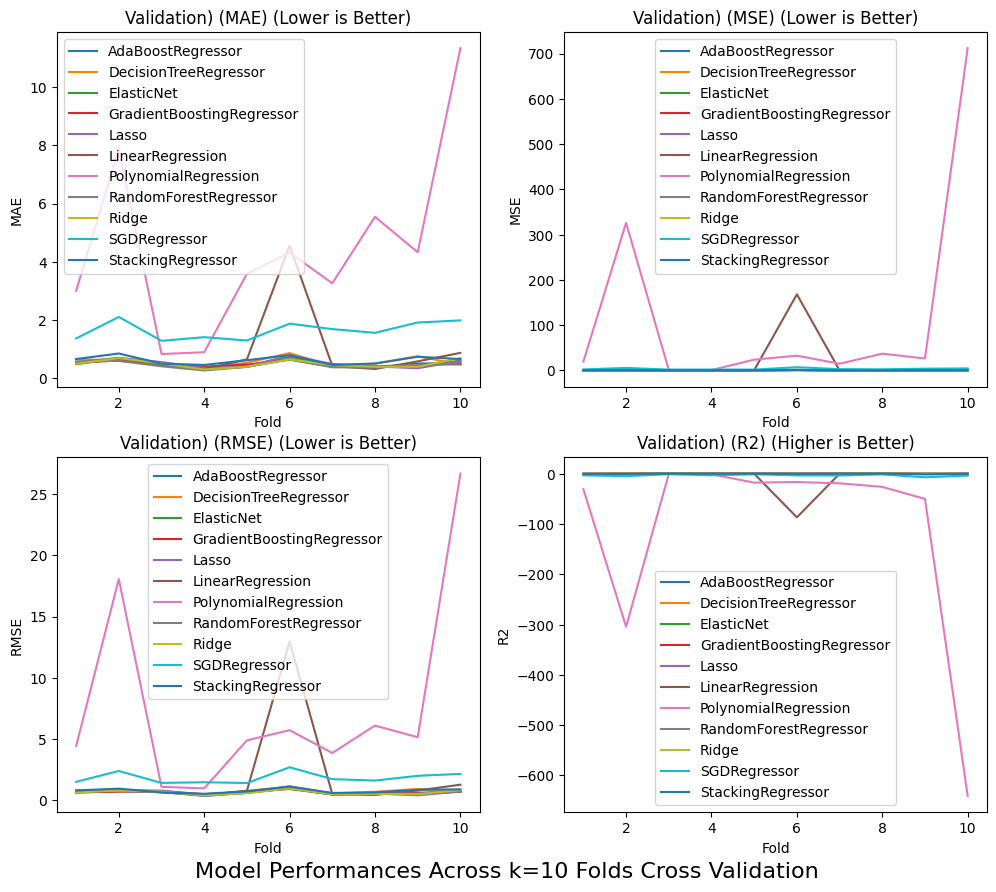

In [9]:
# Example usage
plot_model_performance(val_kfold_cv, "Validation)", "Model Performances Across k=10 Folds Cross Validation")

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import RidgeCV
from tqdm import tqdm

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42),
    "Lasso": Lasso(alpha=0.1, precompute=True, warm_start=True, positive=True, selection='random', random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42),
    "PolynomialRegression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "SGDRegressor": SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=1000, random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "StackingRegressor": StackingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('ridge', RidgeCV()),
            ('svr', LinearSVR(dual="auto", max_iter=100000, random_state=42))  # Increase max_iter here
        ],
        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    )
}

# Initialize lists to store results
train_results = []
val_results = []

# Define Leave-One-Out cross-validation
loo = LeaveOneOut()

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Perform cross-validation
for model_name, model in tqdm(models.items(), desc="Models", total=len(models)):
    for train_index, val_index in loo.split(X_normalized):
        X_train, X_val = X_normalized[train_index], X_normalized[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Flatten y
        y_train = np.ravel(y_train)
        y_val = np.ravel(y_val)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val.reshape(1, -1))  # Reshape validation set for single sample prediction

        # Calculate metrics
        train_mae = mean_absolute_error(y_train, train_pred)
        val_mae = mean_absolute_error(y_val, val_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        val_mse = mean_squared_error(y_val, val_pred)
        train_rmse = root_mean_squared_error(y_train, train_pred)
        val_rmse = root_mean_squared_error(y_val, val_pred)
        train_r2 = r2_score(y_train, train_pred)
        # Only calculate R-squared for training set or when there are more than 1 sample in validation set
        val_r2 = r2_score(y_val, val_pred) if len(y_val) > 1 else np.nan

        # Append results to lists
        train_results.append([model_name, train_mae, train_mse, train_rmse, train_r2])
        val_results.append([model_name, val_mae, val_mse, val_rmse, val_r2])

# Convert results to DataFrames
train_columns = ["Model", "MAE", "MSE", "RMSE", "R2"]
val_columns = ["Model", "MAE", "MSE", "RMSE", "R2"]
train_loocv = pd.DataFrame(train_results, columns=train_columns)

# condense the results to show the mean of the results, sorted by R2
train_loocv.groupby('Model').mean().sort_values(by='R2', ascending=False)

Models: 100%|██████████| 11/11 [02:27<00:00, 13.43s/it]


,MAE,MSE,RMSE,R2
Model,,,,
PolynomialRegression,8.513763e-15,1.623608e-28,1.244174e-14,1.000000
GradientBoostingRegressor,6.618929e-02,8.177562e-03,9.032632e-02,0.993177
RandomForestRegressor,1.730779e-01,5.979622e-02,2.445083e-01,0.950121
DecisionTreeRegressor,2.182783e-01,8.933935e-02,2.986605e-01,0.925477
AdaBoostRegressor,2.627104e-01,9.464508e-02,3.075809e-01,0.921045
LinearRegression,4.109268e-01,2.930847e-01,5.413417e-01,0.755517
ElasticNet,4.415765e-01,3.456180e-01,5.878709e-01,0.711687
Ridge,4.441534e-01,3.481336e-01,5.900087e-01,0.709585
StackingRegressor,4.614696e-01,3.791547e-01,6.151185e-01,0.683718


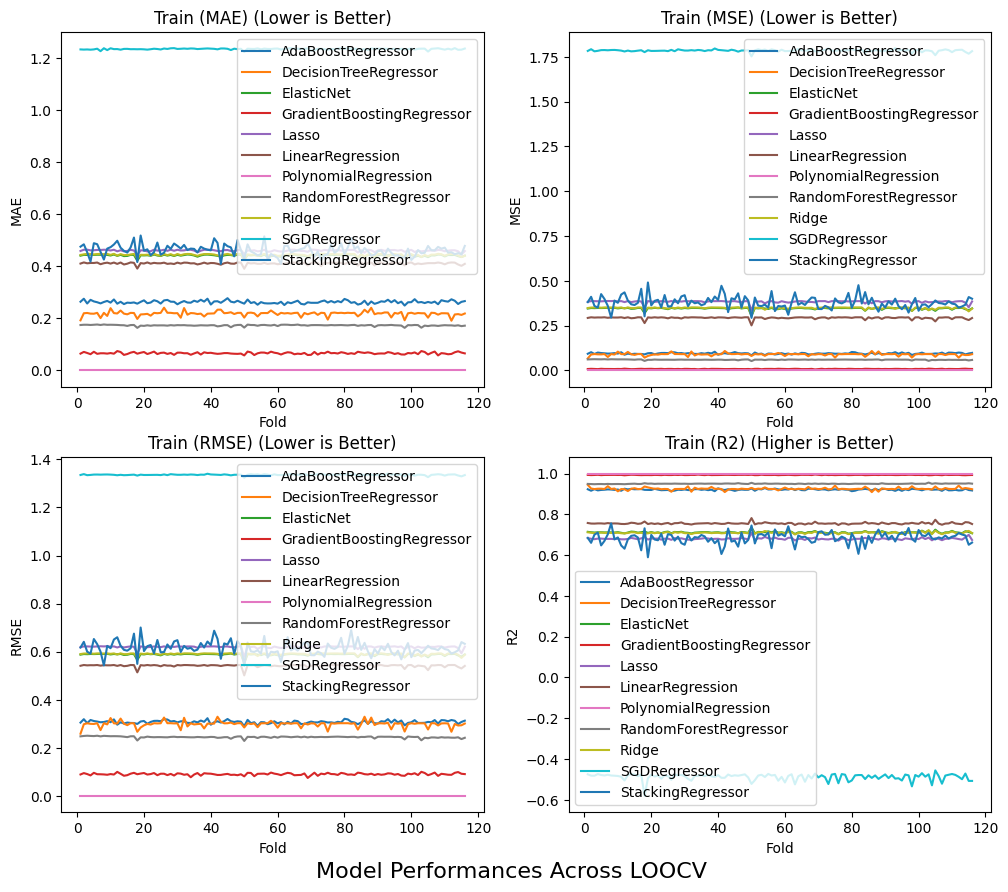

In [11]:
# Example usage
plot_model_performance(train_loocv, "Train", "Model Performances Across LOOCV")

In [12]:
val_loocv = pd.DataFrame(val_results, columns=val_columns)
# condense the results to show the mean of the results, sorted by RMSE, and drop the R2 column
val_loocv.groupby('Model').mean().sort_values(by='RMSE', ascending=True).drop('R2', axis=1)

,MAE,MSE,RMSE
Model,,,
RandomForestRegressor,0.469661,0.440128,0.469661
Ridge,0.489964,0.436779,0.489964
ElasticNet,0.493088,0.440696,0.493088
AdaBoostRegressor,0.496716,0.446074,0.496716
Lasso,0.508975,0.478921,0.508975
GradientBoostingRegressor,0.510752,0.485116,0.510752
DecisionTreeRegressor,0.520723,0.566722,0.520723
StackingRegressor,0.614966,0.655282,0.614966
LinearRegression,0.846430,11.135237,0.846430


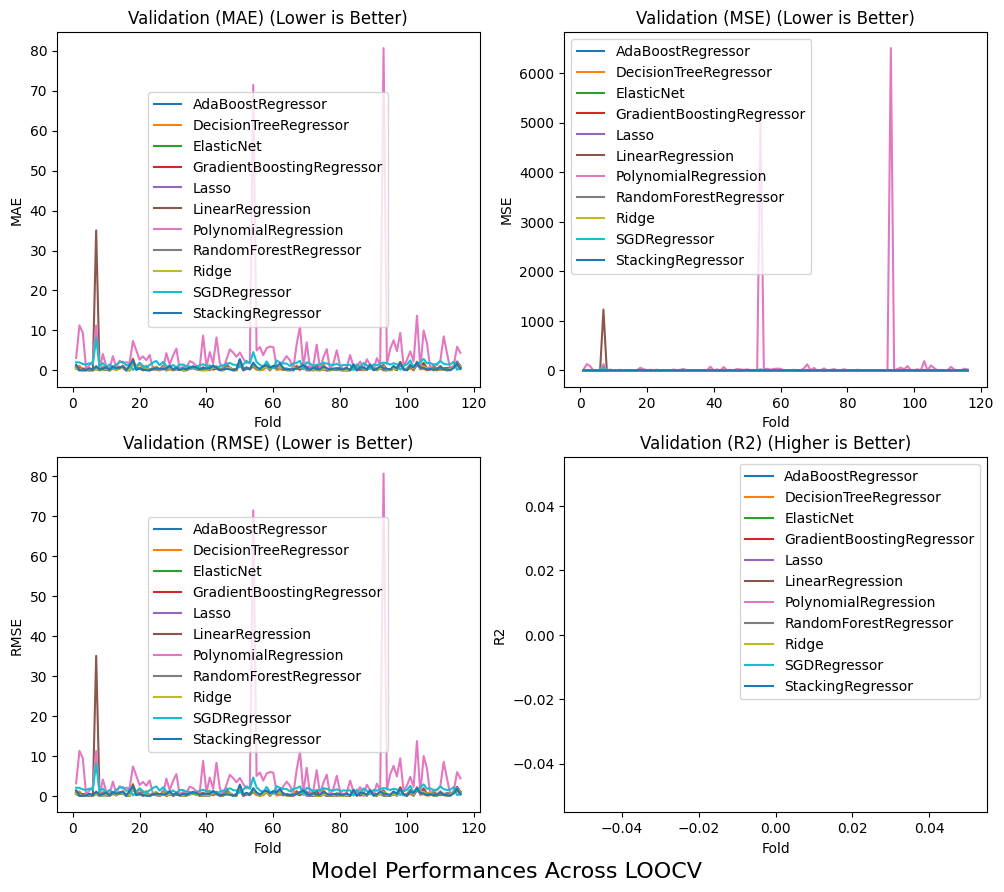

In [13]:
# Example usage
plot_model_performance(val_loocv, "Validation", "Model Performances Across LOOCV")

In [14]:
def calculate_feature_importance(model):
    """
    Calculate feature importance for a given model.

    Parameters:
    model: scikit-learn estimator
        The trained model for which feature importance needs to be calculated.

    Returns:
    feature_importance: dict
        Dictionary containing feature names as keys and their corresponding importance as values.
    """
    feature_importance = {}
    
    if hasattr(model, 'coef_'):  # Linear models
        coef_abs = abs(model.coef_)
        total_importance = sum(coef_abs)
        for i, coef in enumerate(coef_abs):
            feature_importance[f"X{i+1}"] = coef / total_importance

    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        total_importance = sum(model.feature_importances_)
        for i, importance in enumerate(model.feature_importances_):
            feature_importance[f"X{i+1}"] = importance / total_importance

    return feature_importance

# Create an empty dictionary to store feature importance for each model
feature_importance_dict = {}

# Calculate feature importance for each model
for name, model in models.items():
    # Train the model if it's not already trained
    if not hasattr(model, 'feature_importances_') and not hasattr(model, 'coef_'):
        model.fit(X_train, y_train)
    
    # Calculate feature importance
    feature_importance_dict[name] = calculate_feature_importance(model)

# Convert the dictionary to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance_dict).T

# Reset index and rename columns
feature_importance_df.reset_index(inplace=True)
feature_importance_df.rename(columns={'index': 'model_name'}, inplace=True)

# Print feature importance DataFrame
feature_importance_df

,model_name,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
0,LinearRegression,0.008094,0.117497,0.020484,0.016974,0.024950,0.080176,0.095195,0.030870,0.067773,...,0.064327,0.069317,0.041323,0.017023,0.022074,0.004117,0.073755,0.029654,0.033877,0.081154
1,Ridge,0.067094,0.097735,0.010692,0.003129,0.022323,0.087354,0.085347,0.032848,0.000603,...,0.075165,0.006998,0.018023,0.060480,0.046679,0.070108,0.084703,0.078978,0.002299,0.027674
2,Lasso,0.000000,0.236123,0.000000,0.000000,0.000000,0.000000,0.141974,0.000000,0.000000,...,0.130623,0.000000,0.000000,0.000000,0.005510,0.142067,0.100946,0.168853,0.000000,0.000000
3,ElasticNet,0.000000,0.175210,0.000000,0.000000,0.000000,0.111256,0.150577,0.000000,0.000000,...,0.086692,0.000000,0.000000,0.039858,0.000000,0.095773,0.116111,0.152293,0.000000,0.000000
4,PolynomialRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SGDRegressor,0.059843,0.101107,0.003950,0.001939,0.015323,0.108828,0.078770,0.029528,0.017085,...,0.067106,0.010612,0.009024,0.042426,0.041922,0.070161,0.087667,0.065931,0.007116,0.036498
6,DecisionTreeRegressor,0.000000,0.073192,0.000000,0.000000,0.017997,0.024899,0.114755,0.000000,0.568836,...,0.000000,0.011015,0.085855,0.000000,0.019467,0.000000,0.000000,0.001861,0.050433,0.019363
7,RandomForestRegressor,0.022686,0.298741,0.008056,0.004364,0.021433,0.015661,0.051177,0.012935,0.284245,...,0.047138,0.010909,0.017472,0.024037,0.020068,0.009443,0.024964,0.036907,0.010927,0.013001
8,AdaBoostRegressor,0.031595,0.100384,0.007859,0.002693,0.031776,0.042031,0.091042,0.015341,0.146756,...,0.061253,0.019155,0.009914,0.160901,0.011385,0.047179,0.031210,0.041054,0.023427,0.010526
9,GradientBoostingRegressor,0.011388,0.308808,0.007832,0.003709,0.028241,0.022582,0.089287,0.002575,0.292256,...,0.047830,0.015088,0.045739,0.000512,0.011402,0.011223,0.027508,0.011161,0.009808,0.013882


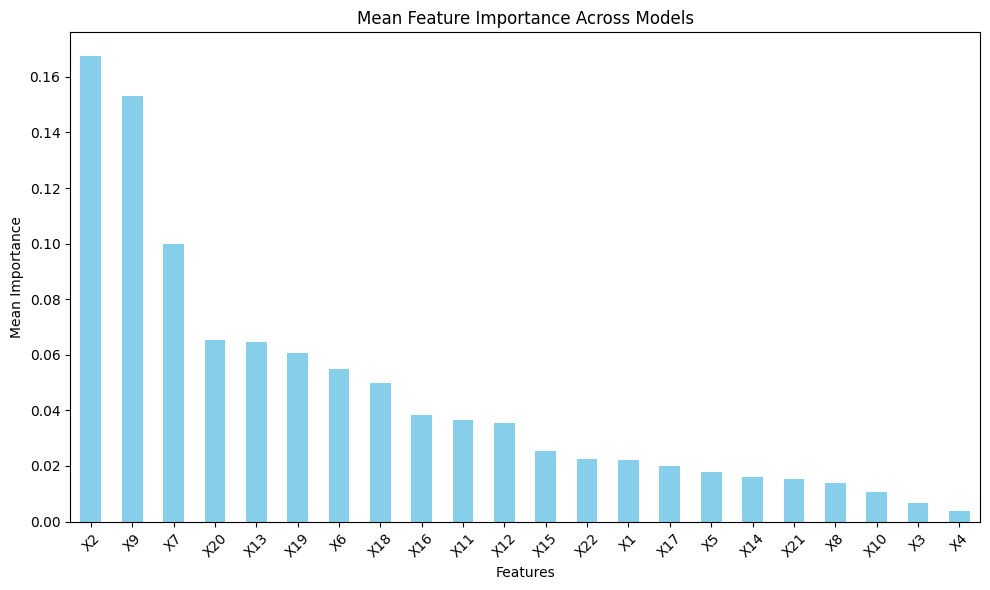

In [15]:
import matplotlib.pyplot as plt

# Drop rows where all feature columns are NaN for each model
feature_importance_df.dropna(axis=0, how='all', inplace=True)

# Calculate mean feature importance
mean_feature_importance = feature_importance_df.drop(columns='model_name').mean()

# Plotting the mean feature importance
plt.figure(figsize=(10, 6))
mean_feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Mean Feature Importance Across Models')
plt.xlabel('Features')
plt.ylabel('Mean Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

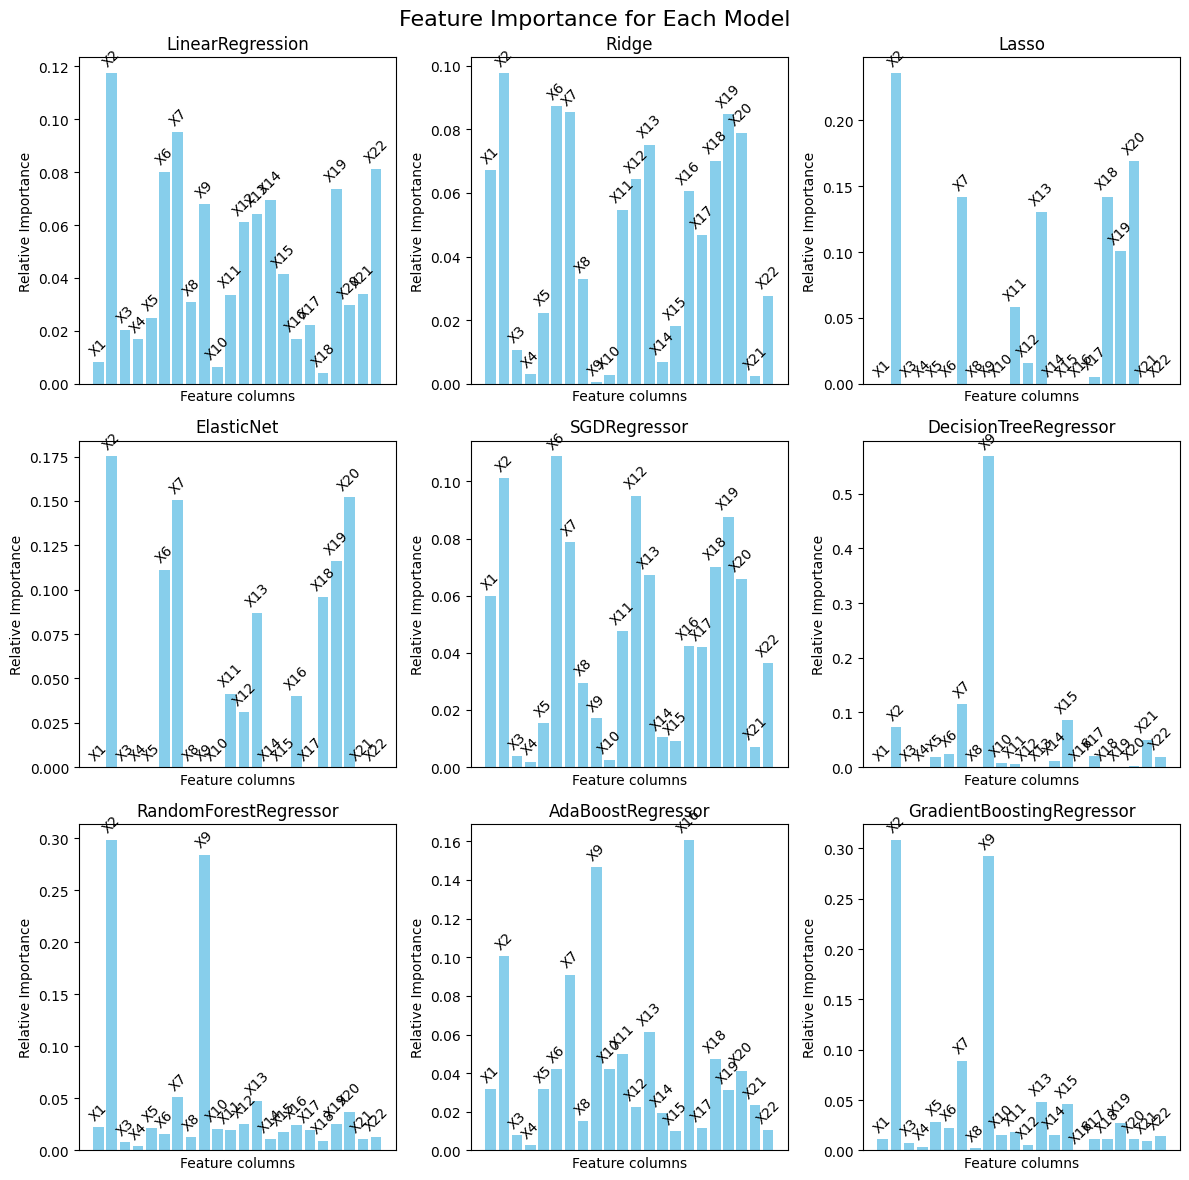

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot bar chart for each model
def plot_feature_importance(models, feature_importance_df):
    num_models = len(models)
    num_features = len(feature_importance_df.columns) - 1  # Exclude model_name column
    num_rows = (num_models + 2) // 3  # Calculate the number of rows required for the grid

    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows), sharex=True)
    fig.suptitle('Feature Importance for Each Model', fontsize=16)

    for i, (name, model) in enumerate(models.items()):
        # Calculate the position of the subplot
        row = i // 3
        col = i % 3

        # Get feature importance for the current model
        model_feature_importance = feature_importance_df.loc[feature_importance_df['model_name'] == name].drop(columns='model_name').values.flatten()
        
        # Plot bar chart
        ax = axes[row, col]
        bars = ax.bar(range(num_features), model_feature_importance, color='skyblue')
        ax.set_title(name)
        ax.set_ylabel('Relative Importance')
        ax.set_xticks([])
        ax.set_xlabel('Feature columns')  # Set common label for x-axis

        # Annotate bars with feature names
        for bar, feature_name in zip(bars, feature_importance_df.columns[1:]):
            height = bar.get_height()
            ax.annotate(feature_name,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=45)

    # Hide any remaining empty subplots
    for i in range(len(models), num_rows * 3):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Plot feature importance for each model (remove PolynomialRegression and StackingRegressor from models dict and feature_importance_df)
plot_feature_importance({k: v for k, v in models.items() if k not in ['PolynomialRegression', 'StackingRegressor']}, 
                        feature_importance_df.drop(feature_importance_df.index[[4, 10]]))

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def bayesian_paired_comparison(model1_scores, model2_scores, prior_mean=0, prior_std=1):
    """
    Compute the Bayesian estimate of how likely one model performs better than another.

    Parameters:
        model1_scores (array-like): Array of performance scores of model 1.
        model2_scores (array-like): Array of performance scores of model 2.
        prior_mean (float): Mean of the prior distribution (default is 0).
        prior_std (float): Standard deviation of the prior distribution (default is 1).

    Returns:
        likelihood: The probability that model 1 performs better than model 2.
        significance: The statistical significance of the result.
    """
    # Compute differences in performance scores
    score_diffs = np.array(model1_scores) - np.array(model2_scores)

    # Compute the posterior distribution parameters
    posterior_mean = prior_mean + np.mean(score_diffs)
    posterior_std = np.sqrt(prior_std**2 + np.var(score_diffs))

    # Compute the probability that model 1 performs better than model 2
    likelihood = norm.cdf(0, loc=posterior_mean, scale=posterior_std)

    # Compute the statistical significance
    significance = 2 * min(likelihood, 1 - likelihood)

    return likelihood, significance


# Define models
models = val_kfold_cv['Model'].unique()

# Initialize dictionary to store wins
model_wins = {model: 0 for model in models}

# Define function to extract scores for a model
def get_model_scores(model_name):
    return val_kfold_cv[val_kfold_cv['Model'] == model_name][['MAE', 'MSE', 'RMSE', 'R2']].values

# Perform pairwise comparison
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        model1_name = models[i]
        model2_name = models[j]

        # Extract scores for both models
        model1_scores = get_model_scores(model1_name)
        model2_scores = get_model_scores(model2_name)

        # Compute likelihood and significance
        likelihood, significance = bayesian_paired_comparison(model1_scores, model2_scores)

        # Determine the winner
        if likelihood > 0.5:
            winner = model1_name
            model_wins[model1_name] += 1
        else:
            winner = model2_name
            model_wins[model2_name] += 1

        # save the results to a csv file
        with open('data/bayes-t-test-results.csv', 'a') as f:
            f.write(f"{model1_name},{model2_name},{winner},{likelihood},{significance}\n")

# Print the number of wins for each model
print("\nNumber of Wins for Each Model:")
# sort the dictionary by values
model_wins = {k: v for k, v in sorted(model_wins.items(), key=lambda item: item[1], reverse=True)}
for model, wins in model_wins.items():
    print(f"{model}: {wins}")


Number of Wins for Each Model:
RandomForestRegressor: 10
AdaBoostRegressor: 9
GradientBoostingRegressor: 8
Ridge: 7
ElasticNet: 6
Lasso: 5
DecisionTreeRegressor: 4
StackingRegressor: 3
SGDRegressor: 2
LinearRegression: 1
PolynomialRegression: 0


  3%|▎         | 1/36 [01:14<43:12, 74.08s/it]


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Score (Negative MSE): -0.41676801797151475


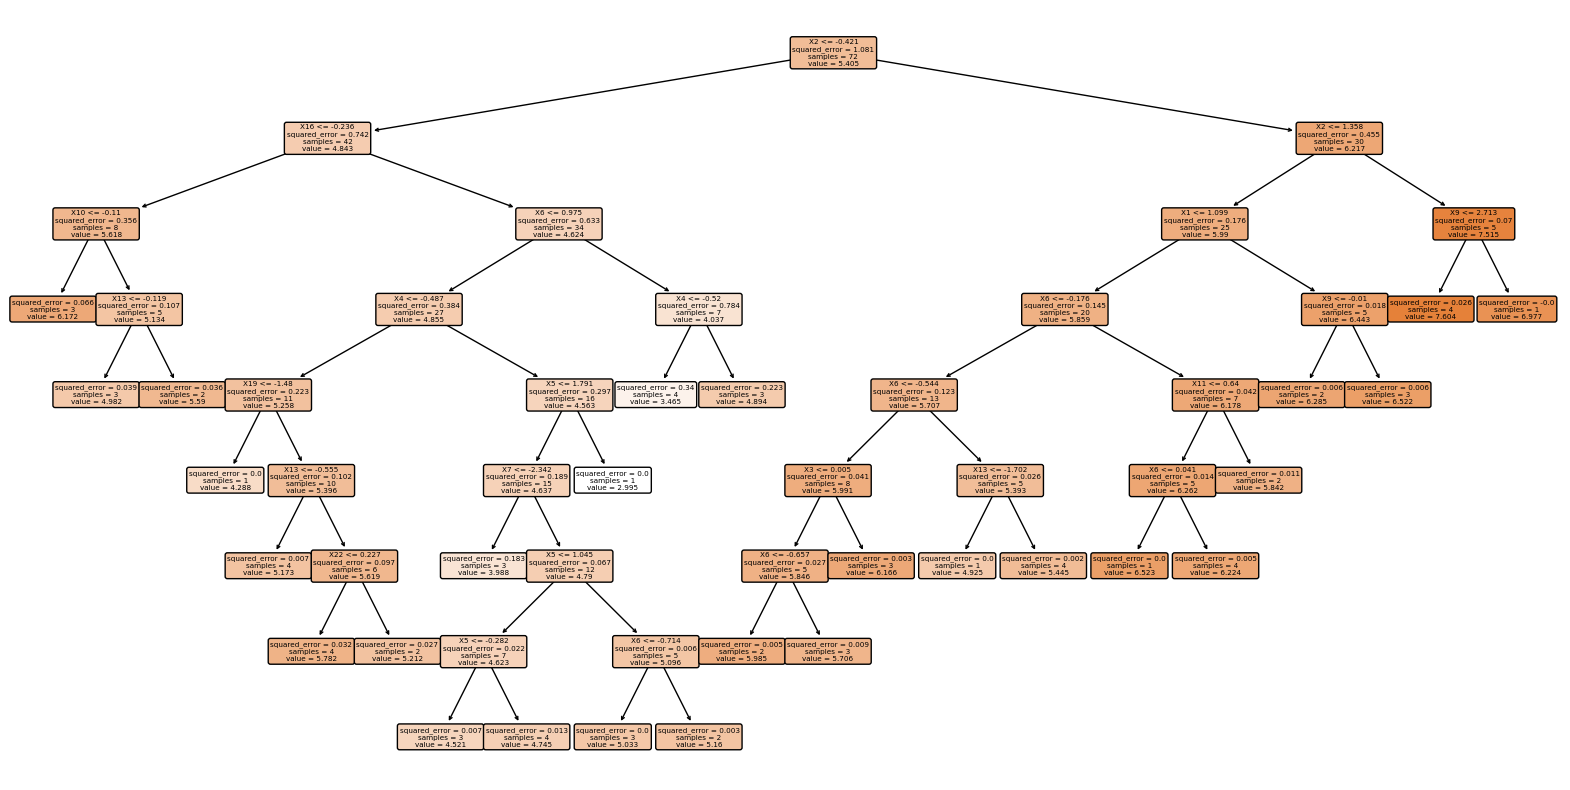

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming X_train, X_val, y_train, y_val are defined from previous code

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000],  # Vary the number of trees
    'max_depth': [None, 10, 20, 30],    # Vary the maximum depth of trees
    'min_samples_split': [2, 5, 10]     # Vary the minimum number of samples required to split a node
}

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search
with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])) as pbar:
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_train, y_train)
    pbar.update()

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (Negative MSE):", best_score)

# Get the best model
best_rf = grid_search.best_estimator_

# Visualize the best tree
best_tree = best_rf.estimators_[0]  # Get the first tree from the forest (you can change this index)
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=columns_names, filled=True, rounded=True)  # Pass column names here
plt.show()